In [1]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests, adfuller

import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# **I. LOAD DATA**

In [3]:
eur = pd.read_csv("/content/drive/MyDrive/Ngiu Ân/EUR_USD Historical Data.csv")
periods = 1
eur["Date"] = pd.to_datetime(eur["Date"])
eur = eur.sort_values(by=['Date']).reset_index()[["Date", "Price", "Open", "High", "Low"]].rename(columns={"Price":"Close"})
eur["Return"] = eur["Close"].pct_change(periods=periods) * 10
eur = eur.iloc[periods:]
eur

,Date,Close,Open,High,Low,Return
1,2004-01-02,1.2587,1.2543,1.2632,1.2523,0.039081
2,2004-01-05,1.2662,1.2584,1.2697,1.2583,0.059585
3,2004-01-06,1.2731,1.2664,1.2814,1.2664,0.054494
4,2004-01-07,1.2639,1.2733,1.2745,1.2633,-0.072265
5,2004-01-08,1.2763,1.2632,1.2782,1.2561,0.098109
...,...,...,...,...,...,...
4995,2023-02-23,1.0595,1.0603,1.0628,1.0576,-0.005660
4996,2023-02-24,1.0546,1.0597,1.0616,1.0536,-0.046248
4997,2023-02-27,1.0607,1.0541,1.0620,1.0532,0.057842
4998,2023-02-28,1.0576,1.0605,1.0646,1.0574,-0.029226


# **II. ARIMA**

Mean value:  1.2443250850170036
Max value:  1.5988
Min value:  0.9592
% above mean:  0.47649529905981197
% below mean:  0.5235047009401881


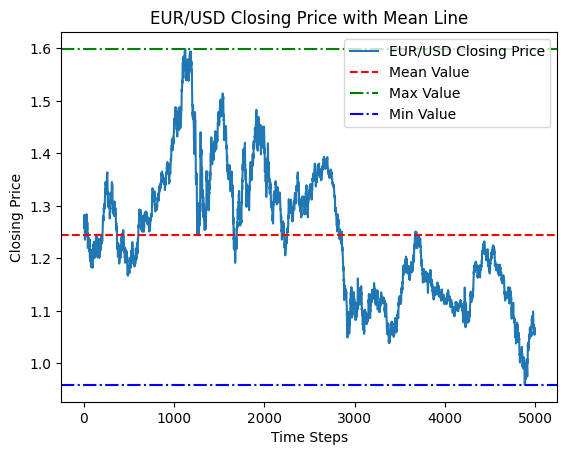

In [4]:
# Plot the series
plt.plot(eur["Close"], label='EUR/USD Closing Price')

# Add a horizontal line for the mean value
mean_value = eur["Close"].mean()
plt.axhline(y=mean_value, color='red', linestyle='--', label='Mean Value')

# Add a horizontal line for the maximum value
max_value = eur["Close"].max()
plt.axhline(y=max_value, color='green', linestyle='-.', label='Max Value')

# Add a horizontal line for the minimum value
min_value = eur["Close"].min()
plt.axhline(y=min_value, color='blue', linestyle='-.', label='Min Value')

# % above mean and below mean
pct_above_mean = len(eur[eur["Close"]>= mean_value]) / len(eur)
pct_below_mean = 1 - pct_above_mean

# Print values
print("Mean value: ", mean_value)
print("Max value: ", max_value)
print("Min value: ", min_value)
print("% above mean: ", pct_above_mean)
print("% below mean: ", pct_below_mean)

# Set labels and title
plt.xlabel('Time Steps')
plt.ylabel('Closing Price')
plt.title('EUR/USD Closing Price with Mean Line')

# Show legend
plt.legend()

# Show the plot
plt.show()


In [5]:
# Stationarity Test
# Load the neccessary packages:
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller, zivot_andrews

# Write the function to conduct the adf test
def conduct_adf_test(col):
 result = adfuller(eur[col], autolag = 'AIC')
 print('ADF Statistic: %f' % result[0])
 print('p-value: %f' % result[1])
 print('')

print("ADF Test for Close")
conduct_adf_test("Close")

print("ADF Test for Return")
conduct_adf_test("Return")


ADF Test for Close
ADF Statistic: -1.799832
p-value: 0.380545

ADF Test for Return
ADF Statistic: -70.784176
p-value: 0.000000



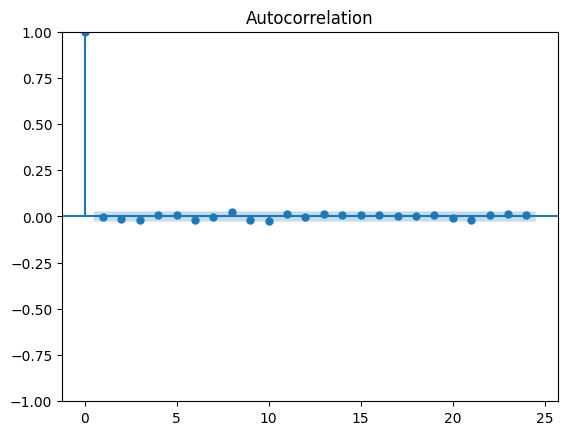

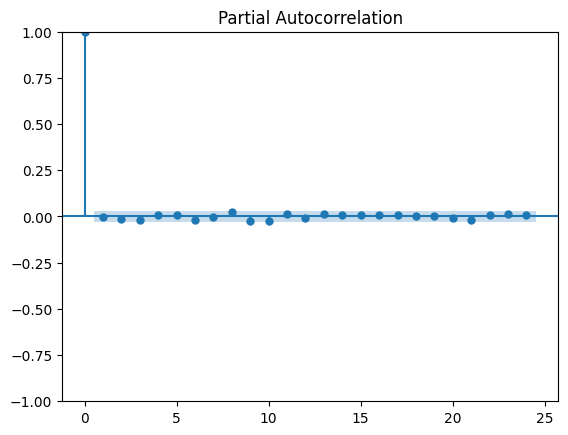

In [6]:
# Plot the autocorrelation function (ACF)
plot_acf(eur["Return"], lags=24)
plt.show()

# Plot the partial autocorrelation function (PACF)
plot_pacf(eur["Return"], lags=24)
plt.show()

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.iolib.summary2 import summary_col

train_data = eur.iloc[:4899]
test_data = eur.iloc[4899:]

# Specify the number of lag values (lag = 30)
lag = 30

# Extract the lag values from the training dataset
train_values = train_data['Return'].values

# Fit an ARIMA(0,0,0) model
model = ARIMA(train_values, order=(1, 0, 1))
result = model.fit()

# Forecast on the testing dataset
forecast = result.forecast(steps=len(test_data))

# Get the statistical summary
summary = summary_col([result], stars=True, float_format="%0.4f", model_names=["ARIMA(1,0,1)"])

# Print and display the summary
print(summary)
summary.as_latex()  # If you're writing a LaTeX document

# Plot the predictions against the actual values
plt.plot(test_data.index, test_data['Return'], label='Actual', color='blue')
plt.plot(test_data.index, forecast, label='Predicted', color='red')
plt.legend()
plt.title('ARIMA(1,0,1) Prediction for EUR/USD Daily Return')
plt.xlabel("Time steps")
plt.ylabel("Daily return")
plt.show()

In [ ]:
def preprocessing_data(data, back_steps=30):
  batch_size = len(data)
  features = ["Close", "High", "Low"]
  num_features = len(features)
  lst_tensor = []

  state_tensor = np.zeros((batch_size, back_steps, num_features), dtype="float32")
  target_tensor = np.zeros((batch_size,1), dtype="float32")

  for i in range(num_features):
    for bid in range(batch_size-back_steps):
      fture = data[features[i]].values[bid:bid+back_steps]
      state_tensor[bid,:,i] = fture
      if i==0:
        try:
          # target = data[features[0]].values[bid+back_steps+1]
          target_tensor[bid] = data["Close"].values[bid+back_steps]
        except:
          pass

  return np.float32(state_tensor[:-back_steps]), np.float32(target_tensor[:-back_steps])
x, y = preprocessing_data(eur)
x.shape, y.shape

In [ ]:
plt.plot(x[:,0,0])
plt.plot(y[:,0],c="g")
plt.show()

In [ ]:
import numpy as np

# Define the axis along which you want to scale (axis=1 for features)
axis_to_scale = 1

# Min-Max scaling along the specified axis
min_vals = x.min(axis=axis_to_scale, keepdims=True)
max_vals = x.max(axis=axis_to_scale, keepdims=True)
x_scaled = (x - min_vals) / (max_vals - min_vals)
x_scaled = np.float32(x_scaled)
x_scaled.shape
# 'features_scaled' now contains the scaled features tensor
plt.plot(x_scaled[:,0,0])
plt.show()


In [ ]:
import numpy as np


# Define the axis along which you want to scale (axis=1 for features)
axis_to_scale = 1

# Min-Max scaling along the specified axis
min_vals = y.min()
max_vals = y.max()
y_scaled = (y - min_vals) / (max_vals - min_vals)
y_scaled = np.float32(y_scaled)
y_scaled.shape

plt.plot(y_scaled[:,0])
plt.show()

# **III. LSTM**

## **III.1 MODEL**

In [ ]:
class LSTM_Model(nn.Module):
  def __init__(self, input_size=3, hidden_size=12, num_layers=2, output_size=1):
    super().__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.output_size = output_size
    # self.tanh = nn.Tanh()
    self.relu = nn.ReLU()
    self.lstm = nn.LSTM(
      input_size = input_size,
      hidden_size = hidden_size,
      num_layers = num_layers,
      batch_first = True
    )
    self.fc0 = nn.Linear(hidden_size, 9)
    self.fc1 = nn.Linear(9,6)
    self.fc2 = nn.Linear(6,output_size)


    init.kaiming_uniform_(
        self.fc0.weight,
        nonlinearity = "sigmoid"
    )

  def forward(self,x):
    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
    c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
    out, _ = self.lstm(x, (h0,c0))
    out = self.relu(self.fc0(out[:,-1, :]))
    out = self.relu(self.fc1(out))
    out = self.fc2(out)
    # out = self.sigmoid(out)
    return out

  def init_weight(self):
    for name, param in self.lstm.named_parameters():
      if 'bias' in name:
        nn.init.constant(param, 0.0)
      elif 'weight' in name:
        nn.init.kaiming_uniform_(param)

# Assuming batch_size=2 for example
batch_size = 2
input_data = torch.randn(batch_size,30,3)

print(input_data.shape)
# Create an instance of the model
lstmModel = LSTM_Model(input_size=3)
# Display the model summary
lstmModel(input_data).shape

## **III.2 DATA LOADER**

In [ ]:
x_train = x[:-100]
y_train = y[:-100]
x_val = x[-100:]
y_val = y[-100:]

class TimeSeriesDataset(TensorDataset):
  def __init__(self, X_data, y_data):
    self.X = X_data
    self.y = y_data

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]

train_dataset = TimeSeriesDataset(x_train, y_train)
val_dataset = TimeSeriesDataset(x_val, y_val)


In [ ]:
batch_size = 100

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=50, shuffle=False)
train_loader

In [ ]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0], batch[1]
    print(x_batch.shape, y_batch.shape)
    break

## **III.3 TRAINING LOOP**

In [ ]:
lstmModel = LSTM_Model(input_size=3)
criterion = nn.L1Loss()
optimizer = optim.Adam(lstmModel.parameters(), lr=0.001, weight_decay=5e-4)
decayRate = 0.96
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decayRate)

num_epoch = 1000
running_loss_epoch = 0
lst_train_loss = []
lst_val_loss = []

total_batchsize_train = 0
for batch_index, _ in enumerate(train_loader):
  total_batchsize_train+=1

total_batchsize_val = 0
for batch_index, _ in enumerate(val_loader):
  total_batchsize_val+=1


for epoch in range(num_epoch):
  lstmModel.train(True)
  print("Epoch: ", epoch+1)
  running_loss = 0
  for batch_index, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0], batch[1]
    # print(x_batch.shape)
    output = lstmModel(x_batch)
    loss = criterion(output, y_batch)
    running_loss += loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if batch_index == total_batchsize_train - 1:
      print("Training Loss: ", running_loss / total_batchsize_train)
      lst_train_loss.append(running_loss/total_batchsize_train)
  # update learning rate
  lr_scheduler.step()

  lstmModel.train(False)
  val_loss = 0
  for batch_index, batch in enumerate(val_loader):
    x_batch, y_batch = batch[0], batch[1]
    with torch.no_grad():
      output = lstmModel(x_batch)
      loss = criterion(output, y_batch)
      val_loss += loss.item()
  val_loss = val_loss / total_batchsize_val
  lst_val_loss.append(val_loss)
  print("Validation Loss: ", val_loss)
  print("----------------------------")

Epoch:  1
Training Loss:  1.2714415423724117
Validation Loss:  0.841448575258255
----------------------------
Epoch:  2
Training Loss:  0.5748934286589525
Validation Loss:  0.18587294965982437
----------------------------
Epoch:  3
Training Loss:  0.10736364856058238
Validation Loss:  0.18359025567770004
----------------------------
Epoch:  4
Training Loss:  0.10329199582338333
Validation Loss:  0.18455291539430618
----------------------------
Epoch:  5
Training Loss:  0.10263766105077704
Validation Loss:  0.18171115964651108
----------------------------
Epoch:  6
Training Loss:  0.09655250487278919
Validation Loss:  0.15749388188123703
----------------------------
Epoch:  7
Training Loss:  0.05390497912861863
Validation Loss:  0.07691814564168453
----------------------------
Epoch:  8
Training Loss:  0.033276748178260665
Validation Loss:  0.03244661446660757
----------------------------
Epoch:  9
Training Loss:  0.02091351628531607
Validation Loss:  0.021479465067386627
--------------

KeyboardInterrupt: ignored

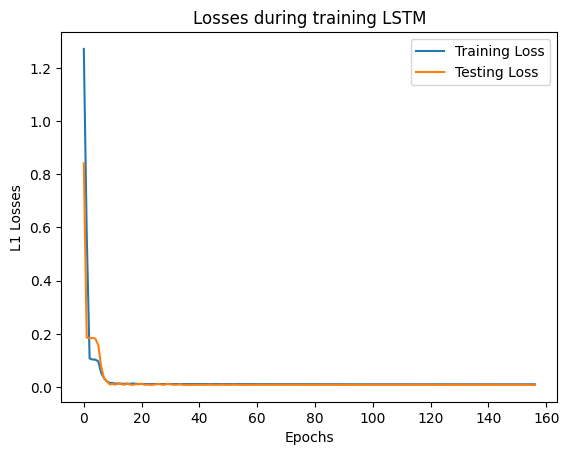

In [ ]:
plt.plot(lst_train_loss, label="Training Loss")
plt.plot(lst_val_loss, label="Testing Loss")
plt.legend()
plt.title("Losses during training LSTM")
plt.xlabel("Epochs")
plt.ylabel("L1 Losses")
plt.show()

torch.Size([4863, 30, 3])
Correlation in training:  0.9940761258697306
Loss in training:  0.006399937
MSE Loss in training:  0.36606205


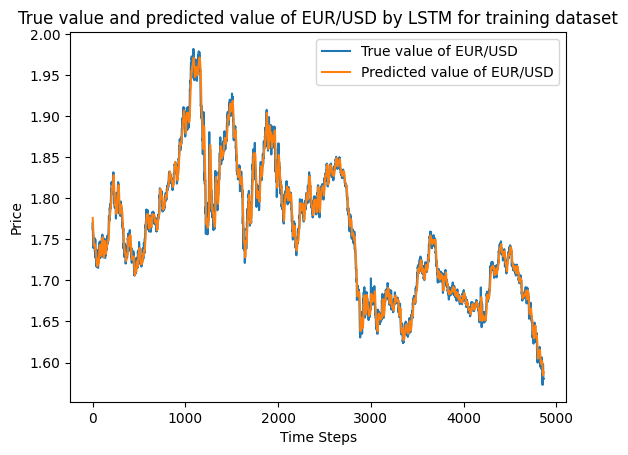

torch.Size([100, 30, 3])
Correlation in validation:  0.9573255331649546
L1 Loss in validation:  0.0050505116
MSE Loss in validation:  0.0043772804


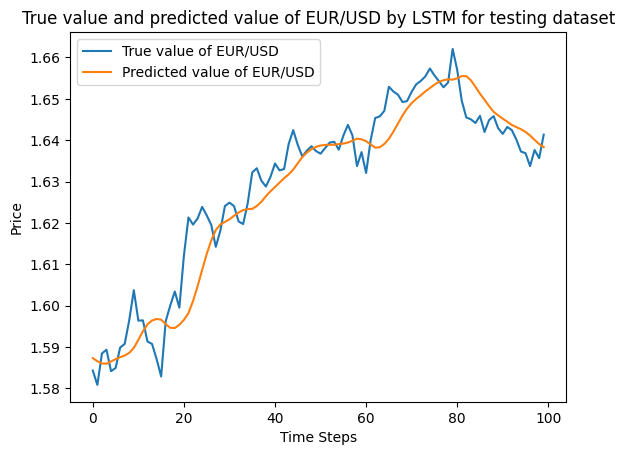

In [ ]:
x_pred = torch.from_numpy(x_train)
print(x_pred.shape)

with torch.no_grad():
  prediction = rnnModel(x_pred).squeeze(1).numpy()

true = pd.Series(y_train.squeeze(1)) * (max_value - min_value) + min_value
prediction = pd.Series(prediction) * (max_value - min_value) + min_value
print("Correlation in training: ",true.corr(prediction))
print("Loss in training: ", np.mean(np.abs(true-prediction)))
print("MSE Loss in training: ", np.mean(np.sum((true-prediction)**2)))

plt.plot(true, label="True value of EUR/USD")
plt.plot(prediction, label="Predicted value of EUR/USD")
plt.legend()
plt.title("True value and predicted value of EUR/USD by LSTM for training dataset")
plt.xlabel("Time Steps")
plt.ylabel("Price")
plt.show()

x_pred = torch.from_numpy(x_val)
print(x_pred.shape)

with torch.no_grad():
  prediction = rnnModel(x_pred).squeeze(1).numpy()

true = pd.Series(y_val.squeeze(1)) * (max_value - min_value) + min_value
prediction = pd.Series(prediction) * (max_value - min_value) + min_value
print("Correlation in validation: ",true.corr(prediction))
print("L1 Loss in validation: ", np.mean(np.abs(true-prediction)))
print("MSE Loss in validation: ", np.mean(np.sum((true-prediction)**2)))

plt.plot(true, label="True value of EUR/USD")
plt.plot(prediction, label="Predicted value of EUR/USD")
plt.legend()
plt.title("True value and predicted value of EUR/USD by LSTM for testing dataset")
plt.xlabel("Time Steps")
plt.ylabel("Price")
plt.show()
